<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#using-ibm_watson-api" data-toc-modified-id="using-ibm_watson-api-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>using ibm_watson api</a></span></li></ul></div>

In [1]:
from IPython.display import HTML
!curl -O https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/src/main/css/custom.css
HTML(open('custom.css', 'r').read())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   348  100   348    0     0   1171      0 --:--:-- --:--:-- --:--:--     0:--:-- --:--:--  1171


In [11]:
# Import required libraries
import pandas as pd
import json
import re
from pandas import json_normalize
from ibm_watson import AssistantV1, AssistantV2
from IPython.display import display
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_cloud_sdk_core.authenticators import BasicAuthenticator

In [16]:
# import the nba api for data 
from nba_api.stats.static import teams

In [18]:
nba_teams = teams.get_teams()

In [27]:
nba_teams[:5]

[{'id': 1610612737,
  'full_name': 'Atlanta Hawks',
  'abbreviation': 'ATL',
  'nickname': 'Hawks',
  'city': 'Atlanta',
  'state': 'Atlanta',
  'year_founded': 1949},
 {'id': 1610612738,
  'full_name': 'Boston Celtics',
  'abbreviation': 'BOS',
  'nickname': 'Celtics',
  'city': 'Boston',
  'state': 'Massachusetts',
  'year_founded': 1946},
 {'id': 1610612739,
  'full_name': 'Cleveland Cavaliers',
  'abbreviation': 'CLE',
  'nickname': 'Cavaliers',
  'city': 'Cleveland',
  'state': 'Ohio',
  'year_founded': 1970},
 {'id': 1610612740,
  'full_name': 'New Orleans Pelicans',
  'abbreviation': 'NOP',
  'nickname': 'Pelicans',
  'city': 'New Orleans',
  'state': 'Louisiana',
  'year_founded': 2002},
 {'id': 1610612741,
  'full_name': 'Chicago Bulls',
  'abbreviation': 'CHI',
  'nickname': 'Bulls',
  'city': 'Chicago',
  'state': 'Illinois',
  'year_founded': 1966}]

In [32]:
nba_teams[0].keys()

dict_keys(['id', 'full_name', 'abbreviation', 'nickname', 'city', 'state', 'year_founded'])

In [33]:
# the nba_team is a list of dicts.
# to make it easier, we should make it into a dict. we create a function for it.
def one_dict(list_dict):
    #take the keys from any of the object to set them as the default keys
    keys = list_dict[0].keys()
    # next we initialize a dict of lists for each key
    out_dict = {key:[] for key in keys}
    for dict_ in list_dict:
        for key, value in dict_.items():
            out_dict[key].append(value)
    return out_dict
one_dict(nba_teams)
    

{'id': [1610612737,
  1610612738,
  1610612739,
  1610612740,
  1610612741,
  1610612742,
  1610612743,
  1610612744,
  1610612745,
  1610612746,
  1610612747,
  1610612748,
  1610612749,
  1610612750,
  1610612751,
  1610612752,
  1610612753,
  1610612754,
  1610612755,
  1610612756,
  1610612757,
  1610612758,
  1610612759,
  1610612760,
  1610612761,
  1610612762,
  1610612763,
  1610612764,
  1610612765,
  1610612766],
 'full_name': ['Atlanta Hawks',
  'Boston Celtics',
  'Cleveland Cavaliers',
  'New Orleans Pelicans',
  'Chicago Bulls',
  'Dallas Mavericks',
  'Denver Nuggets',
  'Golden State Warriors',
  'Houston Rockets',
  'Los Angeles Clippers',
  'Los Angeles Lakers',
  'Miami Heat',
  'Milwaukee Bucks',
  'Minnesota Timberwolves',
  'Brooklyn Nets',
  'New York Knicks',
  'Orlando Magic',
  'Indiana Pacers',
  'Philadelphia 76ers',
  'Phoenix Suns',
  'Portland Trail Blazers',
  'Sacramento Kings',
  'San Antonio Spurs',
  'Oklahoma City Thunder',
  'Toronto Raptors',
  'U

In [36]:
nba_teams_dict = one_dict(nba_teams)

In [38]:
nba_teams_dict['id']

[1610612737,
 1610612738,
 1610612739,
 1610612740,
 1610612741,
 1610612742,
 1610612743,
 1610612744,
 1610612745,
 1610612746,
 1610612747,
 1610612748,
 1610612749,
 1610612750,
 1610612751,
 1610612752,
 1610612753,
 1610612754,
 1610612755,
 1610612756,
 1610612757,
 1610612758,
 1610612759,
 1610612760,
 1610612761,
 1610612762,
 1610612763,
 1610612764,
 1610612765,
 1610612766]

In [39]:
## Convert the dict to a dataframe
df_teams = pd.DataFrame(nba_teams_dict)
df_teams.head()

,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966


In [40]:
## to find table about a team, create a df for them using nickname(or whatever)
df_cavaliers = df_teams[df_teams['nickname']=='Cavaliers']

In [48]:
#id_cavaliers = 
df_cavaliers[['id']].values[0][0]

1610612739

In [50]:
# now we have an id key variable to do work
# This is specific to using API's
## it is like using a shell_variable...
id_cavaliers = df_cavaliers[['id']].values[0][0]

In [51]:
from nba_api.stats.endpoints import leaguedashlineups, leaguegamefinder, leaguedashptstats

In [52]:
help(leaguegamefinder)

Help on module nba_api.stats.endpoints.leaguegamefinder in nba_api.stats.endpoints:

NAME
    nba_api.stats.endpoints.leaguegamefinder

CLASSES
    nba_api.stats.endpoints._base.Endpoint(builtins.object)
        LeagueGameFinder
    
    class LeagueGameFinder(nba_api.stats.endpoints._base.Endpoint)
     |  LeagueGameFinder(player_or_team_abbreviation='T', conference_nullable='', date_from_nullable='', date_to_nullable='', division_simple_nullable='', draft_number_nullable='', draft_round_nullable='', draft_team_id_nullable='', draft_year_nullable='', eq_ast_nullable='', eq_blk_nullable='', eq_dd_nullable='', eq_dreb_nullable='', eq_fg3a_nullable='', eq_fg3m_nullable='', eq_fg3_pct_nullable='', eq_fga_nullable='', eq_fgm_nullable='', eq_fg_pct_nullable='', eq_fta_nullable='', eq_ftm_nullable='', eq_ft_pct_nullable='', eq_minutes_nullable='', eq_oreb_nullable='', eq_pf_nullable='', eq_pts_nullable='', eq_reb_nullable='', eq_stl_nullable='', eq_td_nullable='', eq_tov_nullable='', game_id

In [54]:
# This will make an http request.
# the response will be save as a variable gamefinder as a json directory or payload
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=id_cavaliers)

In [68]:
games = gamefinder.get_data_frames()[0]

In [69]:
games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22020,1610612739,CLE,Cleveland Cavaliers,0022001067,2021-05-16,CLE @ BKN,L,239,109,...,0.677,11,34,45,16,8,5,14,14,-14.0
1,22020,1610612739,CLE,Cleveland Cavaliers,0022000204,2021-05-14,CLE @ WAS,L,240,105,...,0.810,7,37,44,24,4,3,17,21,-15.0
2,22020,1610612739,CLE,Cleveland Cavaliers,0022001044,2021-05-12,CLE vs. BOS,W,240,102,...,0.815,7,48,55,27,4,6,15,13,8.0
3,22020,1610612739,CLE,Cleveland Cavaliers,0022001027,2021-05-10,CLE vs. IND,L,241,102,...,0.767,15,35,50,21,8,2,10,13,-9.0
4,22020,1610612739,CLE,Cleveland Cavaliers,0022001021,2021-05-09,CLE vs. DAL,L,241,97,...,0.645,10,28,38,18,5,2,14,12,-27.0


In [78]:
# MATCHUP column: @ means away game, vs. mean a home game.
games[['MATCHUP']].head(20)
# Creating 2 dataframes, one for home and the other for away

,MATCHUP
0,CLE @ BKN
1,CLE @ WAS
2,CLE vs. BOS
3,CLE vs. IND
4,CLE vs. DAL
5,CLE @ DAL
6,CLE vs. POR
7,CLE vs. PHX
8,CLE vs. MIA
9,CLE vs. WAS


In [122]:
# using row 17 as an example of CLE vs. GSW for the way
# GSW: Golden State warriors
games_home = games[games['MATCHUP']== 'CLE @ GSW']
games_away = games[games['MATCHUP']==games['MATCHUP'][17]]

In [123]:
#games_home.sort_values(by=['GAME_DATE'], inplace=True)
#games_away.sort_values(by=['GAME_DATE'], inplace=True)

In [124]:
games_away.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
17,22020,1610612739,CLE,Cleveland Cavaliers,0022000841,2021-04-15,CLE vs. GSW,L,240,101,...,0.778,8,31,39,21,11,2,13,20,-18.0
91,22019,1610612739,CLE,Cleveland Cavaliers,0021900730,2020-02-01,CLE vs. GSW,L,240,112,...,1.000,13,33,46,26,8,3,15,15,-19.0
211,22018,1610612739,CLE,Cleveland Cavaliers,0021800355,2018-12-05,CLE vs. GSW,L,240,105,...,0.696,12,29,41,17,7,2,10,19,-17.4
246,42017,1610612739,CLE,Cleveland Cavaliers,0041700404,2018-06-08,CLE vs. GSW,L,242,85,...,0.680,17,27,44,21,5,5,11,22,-23.0
247,42017,1610612739,CLE,Cleveland Cavaliers,0041700403,2018-06-06,CLE vs. GSW,L,240,102,...,0.765,15,32,47,20,6,4,13,18,-8.0


<IPython.core.display.Javascript object>


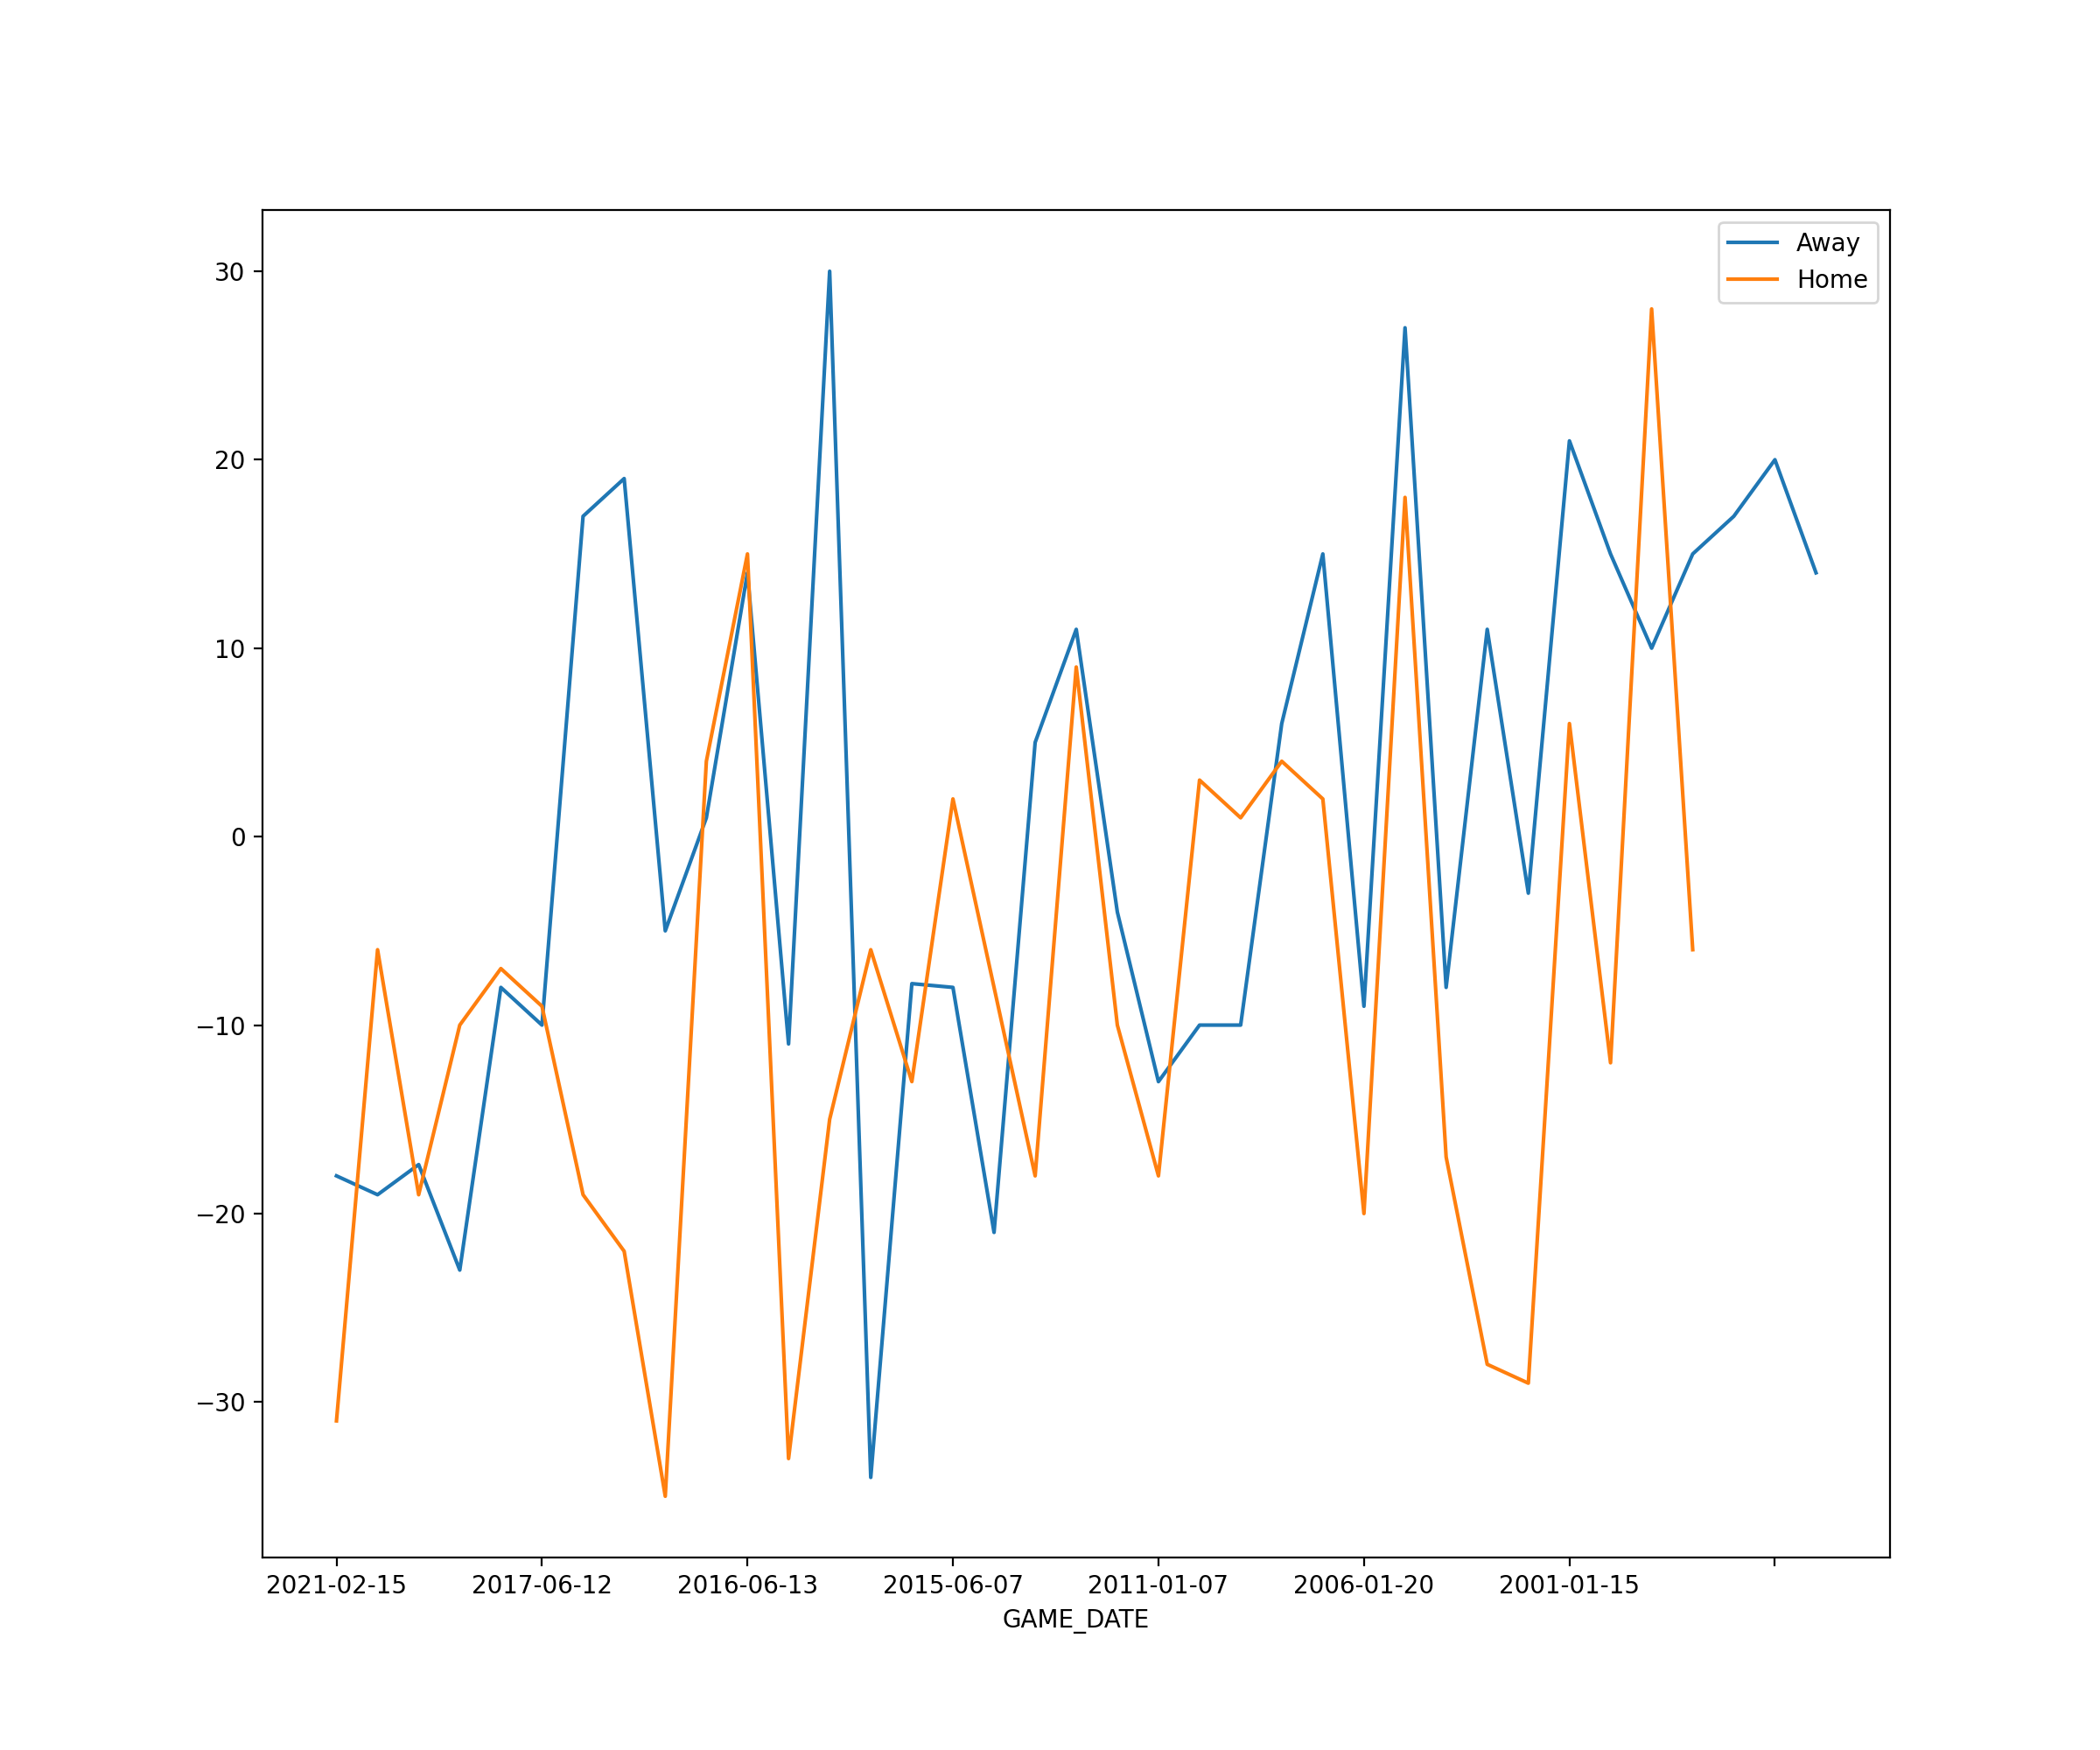

In [126]:
## plot the a line graph to see performance on home-away using the PLUS_MINUS column
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[12, 10]
plt.rcParams['figure.dpi'] =100 # 200 e.g. is really fine, but slower
#fig=plt.figure(figsize=(8,6), dpi=60, facecolor='b', edgecolor='k')#Changing settings on notebook
%matplotlib notebook
#This works better than inline

fig, ax = plt.subplots()
games_away.plot(x='GAME_DATE', y='PLUS_MINUS',ax=ax)
games_home.plot(x='GAME_DATE', y='PLUS_MINUS',ax=ax)
ax.legend(['Away', 'Home'])
plt.show()

# SPEECH to TEXT API
## using ibm_watson api

In [127]:
import ibm_watson

In [128]:
dir(ibm_watson)

['ApiException',
 'AssistantV1',
 'AssistantV2',
 'BaseService',
 'CompareComplyV1',
 'DetailedResponse',
 'DiscoveryV1',
 'DiscoveryV2',
 'IAMTokenManager',
 'LanguageTranslatorV3',
 'NaturalLanguageClassifierV1',
 'NaturalLanguageUnderstandingV1',
 'PersonalityInsightsV3',
 'SpeechToTextV1',
 'TextToSpeechV1',
 'ToneAnalyzerV3',
 'VisualRecognitionV3',
 'VisualRecognitionV4',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'assistant_v1',
 'assistant_v2',
 'common',
 'compare_comply_v1',
 'discovery_v1',
 'discovery_v2',
 'get_sdk_headers',
 'language_translator_v3',
 'natural_language_classifier_v1',
 'natural_language_understanding_v1',
 'personality_insights_v3',
 'speech_to_text_v1',
 'speech_to_text_v1_adapter',
 'text_to_speech_adapter_v1',
 'text_to_speech_v1',
 'tone_analyzer_v3',
 'version',
 'visual_recognition_v3',
 'visual_recognition_v4',
 'websocket']

In [129]:
from ibm_watson import speech_to_text_v1

In [130]:
from ibm_watson import SpeechToTextV1

In [131]:
dir(SpeechToTextV1)

['DEFAULT_SERVICE_NAME',
 'DEFAULT_SERVICE_URL',
 'ERROR_MSG_DISABLE_SSL',
 'SDK_NAME',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_user_agent',
 '_convert_list',
 '_convert_model',
 '_encode_path_vars',
 '_get_system_info',
 '_set_user_agent_header',
 'add_audio',
 'add_corpus',
 'add_grammar',
 'add_word',
 'add_words',
 'check_job',
 'check_jobs',
 'configure_service',
 'create_acoustic_model',
 'create_job',
 'create_language_model',
 'delete_acoustic_model',
 'delete_audio',
 'delete_corpus',
 'delete_grammar',
 'delete_job',
 'delete_language_model',
 'delete_user_data',
 'delete_word',
 'disable_retries',
 'enable_retries',
 'encode_path_vars',
 'get

In [137]:
SpeechToTextV1.DEFAULT_SERVICE_NAME

'speech_to_text'

In [142]:
url_s2t = 'https://stream.watsonplatform.net/speech-to-text/api'
export IAM_ACCESS_GROUPS_URL=url_s2t
export IAM_ACCESS_GROUPS_AUTHTYPE=iam
export IAM_ACCESS_GROUPS_APIKEY='loPBE-WFIFuCXD7p50t-SKWlBRZ3WqwP2bVVgLld-Rb4'
from ibm_platform_services import IamAccessGroupsV2

service_client = IamAccessGroupsV2.new_instance()



SyntaxError: invalid syntax (<ipython-input-142-c1fa5c6e217f>, line 2)

In [ ]:
loPBE-WFIFuCXD7p50t-SKWlBRZ3WqwP2bVVgLld-Rb4